# Setup Enviroment


In [1]:
!pip install awscli
!pip install boto3 pydub pandas
!sudo apt install ffmpeg  # or brew install ffmpeg on Mac
!sudo apt-get install libsndfile1
!pip install soundfile
!pip install tabulate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.5/570.5 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: rsa
    Found existing installation: rsa 4.9.1
    Uninstalling rsa-4.9.1:
      Successfully uninstalled rsa-4.9.1
  Attempting uninstall: docutils
    Found existing installation: docutils 0.21.2
    Uninstalling docutils-0.21.2:
      Successfully uninstalled docutils-0.21.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sphinx 8.2.3 requires docutils<0.22,>=0.20, but you have docutils 0.19 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 7.9 MB/s eta 0:00:00
Reading package lists... Done
Bui

In [46]:
import os
from google.colab import userdata

os.environ["AWS_ACCESS_KEY_ID"] = userdata.get('AWS_ACCESS_KEY')
os.environ["AWS_SECRET_ACCESS_KEY"] = userdata.get('AWS_SECRET_KEY')
os.environ["AWS_DEFAULT_REGION"] = userdata.get('AWS_REGION_NAME')


In [3]:
!aws configure list



      Name                    Value             Type    Location
      ----                    -----             ----    --------
   profile                <not set>             None    None
access_key     ****************M5FO              env    
secret_key     ****************VNpB              env    
    region               me-south-1              env    AWS_DEFAULT_REGION


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Handle audacity data

In [5]:
!rm -rf content/_wav/

In [6]:
# Requirements:
# !pip install boto3 pydub tqdm tabulate matplotlib
# !apt-get update && apt-get install -y ffmpeg

import os, re, json, math, logging, time, csv
from concurrent.futures import ThreadPoolExecutor, as_completed
from collections import Counter
import boto3, warnings
import pandas as pd
from tqdm import tqdm
from tabulate import tabulate
import matplotlib.pyplot as plt
from pydub import AudioSegment
import glob
import numpy as np


/usr/local/lib/python3.12/dist-packages/pydub/utils.py:300: SyntaxWarning: invalid escape sequence '\('
  m = re.match('([su]([0-9]{1,2})p?) \(([0-9]{1,2}) bit\)$', token)
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:301: SyntaxWarning: invalid escape sequence '\('
  m2 = re.match('([su]([0-9]{1,2})p?)( \(default\))?$', token)
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:310: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(flt)p?( \(default\))?$', token):
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:314: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(dbl)p?( \(default\))?$', token):


In [7]:
#configurations

ROOT_PATH = "/content/drive/MyDrive/Generated Data/TTS/Gemini_audacity/To - AI/SA"
# S3 prefixes
S3_BUCKET = "widebot-ai"
S3_AUDIO_PREFIX = "TTS_V1/TTS_DATA_SA/audio"            # flat audio storage
S3_CSV_PREFIX   = "TTS_V1/TTS_DATA_SA"                  # CSV metadata uploaded here
S3_META_PREFIX  = "TTS_V1/TTS_DATA_SA_Metadata"         # analysis / missing / logs uploaded here

PREFIXES = ["TextToSpeech/Data/SA_Data"]

# persistent tmp (Drive recommended to allow resume across sessions)
TMP_BASE = "/content/drive/MyDrive/Generated Data/TTS/Gemini_audacity/To - AI/MetaData_SA_T1"
LOG_DIR = os.path.join(TMP_BASE, "logs")
STATE_DIR = os.path.join(TMP_BASE, "state")
TMP_WAV_DIR = os.path.join("/content/", "_wav")

SEQ_PADDING = 4            # zero-pad per-batch indexes
DRY_RUN = False            # True = no S3 uploads; set False to actually upload
MAX_WORKERS = 6            # concurrency for batches within a category
VERIF_THRESHOLD = 0.05     # seconds tolerance for verification warnings
PLOT_DASHBOARD = True      # show matplotlib bar chart

# batches with these tokens in name will be skipped
SKIP_PATTERNS = ["duplicate", "dup", "corrupt", "broken"]

# speaker mapping provided by you (fallback for categories)
SPEAKER_MAP = {
    "Cultural": "puck",
    "Furniture": "puck",
    "Hospital": "puck",
    "Saudi_issue_sentences": "puck",
    "Saudi_words_issues": "puck",
    "Second_batch": "puck",
    "Seramic": "puck",
    "Third_batch": "puck",
    "first_batch": "puck",
    "saudi_daily_life": "zephyr",
    "saudi_education": "zephyr",
    "saudi_food": "zephyr",
    "saudi_health": "zephyr",
    "saudi_transport": "zephyr",
    "saudi_work": "zephyr",
    "Saudi_Adam_Podcast": "puck",
    "Saudi_Computer_Reviews": "charon",
    "Saudi_Garema_Podcast": "charon",
    "Saudi_KenbaElsabt_Podcast": "leda",
    "Saudi_Wegdan_Podcast": "puck"
}

donot forget to add fetching data from S3 bucket
--> add flag refer to use (S3 bucket/drive link)

In [8]:
#drive path --> tmp_base
def find_gsa_files(drive_path):
    """
    Find all CSV files starting with G_SA in Google Drive

    Args:
        search_path: Path to search in (default is MyDrive root)
    """
    print(f"Searching in: {drive_path}")
    print(f"Directory exists: {os.path.exists(drive_path)}")

    # List all files in the directory first (for debugging)
    if os.path.exists(drive_path):
        all_files = os.listdir(drive_path)
        print(f"\nAll files in directory: {len(all_files)} items")
        csv_files = [f for f in all_files if f.endswith('.csv')]
        print(f"CSV files found: {csv_files[:10]}")  # Show first 10

    files = []

    # Method 1: Search in current directory
    pattern1 = os.path.join(drive_path, 'G_SA*.csv')
    files1 = glob.glob(pattern1)
    files.extend(files1)

    # Method 2: Search in subdirectories
    pattern2 = os.path.join(drive_path, '**', 'G_SA*.csv')
    files2 = glob.glob(pattern2, recursive=True)
    files.extend(files2)

    # Remove duplicates
    files = list(set(files))

    if not files:
        print(f"\nNo files found starting with 'G_SA'")
        return []

    print(f"\nFound {len(files)} file(s) starting with 'G_SA':")
    for i, file in enumerate(files, 1):
        # Show relative path for readability
        rel_path = file.replace(TMP_BASE, '')
        print(f"{i}. {os.path.basename(file)} - {rel_path}")

    return files

In [9]:
import pandas as pd
import os

def read_gsa_csv(file_path=None, drive_path=TMP_BASE):
    """
    Read G_SA file as raw text (no parsing, no splitting).
    Guaranteed no data loss.
    """
    if file_path is None:
        files = find_gsa_files(drive_path)

        if not files:
            return None

        file_path = files[0]
        print(f"\nReading: {file_path}")

    rows = []
    with open(file_path, encoding="utf-8") as f:
        for line_no, line in enumerate(f, start=1):
            rows.append({
                "line_number": line_no,
                "text": line.rstrip("\n")
            })

    df = pd.DataFrame(rows)
    return df


In [10]:
read_gsa_csv()

Searching in: /content/drive/MyDrive/Generated Data/TTS/Gemini_audacity/To - AI/MetaData_SA_T1
Directory exists: True

All files in directory: 81 items
CSV files found: ['G_SA_cultural.csv', 'analysis_G_SA_cultural.csv', 'missing_G_SA_cultural.csv', 'G_SA_furniture.csv', 'analysis_G_SA_furniture.csv', 'missing_G_SA_furniture.csv', 'G_SA_hospital.csv', 'analysis_G_SA_hospital.csv', 'missing_G_SA_hospital.csv', 'G_SA_saudi_adam_podcast.csv']

Found 24 file(s) starting with 'G_SA':
1. G_SA_saudi_issue_sentences.csv - /G_SA_saudi_issue_sentences.csv
2. G_SA_second_batch.csv - /G_SA_second_batch.csv
3. G_SA_saudi_kenbaelsabt_podcast.csv - /G_SA_saudi_kenbaelsabt_podcast.csv
4. G_SA_saudi_adam_podcast.csv - /G_SA_saudi_adam_podcast.csv
5. G_SA_saudi_health.csv - /G_SA_saudi_health.csv
6. G_SA_third_batch.csv - /G_SA_third_batch.csv
7. G_SA_cultural.csv - /G_SA_cultural.csv
8. G_SA_saudi_daily_life.csv - /G_SA_saudi_daily_life.csv
9. G_SA_first_batch.csv - /G_SA_first_batch.csv
10. G_SA_saudi

,line_number,text
0,1,audio_file|text|speaker_name
1,2,audio/G_SA_saudi_issue_sentences_batch_1_0001....
2,3,audio/G_SA_saudi_issue_sentences_batch_2_0001....
3,4,audio/G_SA_saudi_issue_sentences_batch_2_0002....
4,5,audio/G_SA_saudi_issue_sentences_batch_2_0003....
5,6,audio/G_SA_saudi_issue_sentences_batch_2_0004....
6,7,audio/G_SA_saudi_issue_sentences_batch_2_0005....
7,8,audio/G_SA_saudi_issue_sentences_batch_2_0006....
8,9,audio/G_SA_saudi_issue_sentences_batch_2_0007....
9,10,audio/G_SA_saudi_issue_sentences_batch_2_0008....


In [11]:
df_v = read_gsa_csv()

Searching in: /content/drive/MyDrive/Generated Data/TTS/Gemini_audacity/To - AI/MetaData_SA_T1
Directory exists: True

All files in directory: 81 items
CSV files found: ['G_SA_cultural.csv', 'analysis_G_SA_cultural.csv', 'missing_G_SA_cultural.csv', 'G_SA_furniture.csv', 'analysis_G_SA_furniture.csv', 'missing_G_SA_furniture.csv', 'G_SA_hospital.csv', 'analysis_G_SA_hospital.csv', 'missing_G_SA_hospital.csv', 'G_SA_saudi_adam_podcast.csv']

Found 24 file(s) starting with 'G_SA':
1. G_SA_saudi_issue_sentences.csv - /G_SA_saudi_issue_sentences.csv
2. G_SA_second_batch.csv - /G_SA_second_batch.csv
3. G_SA_saudi_kenbaelsabt_podcast.csv - /G_SA_saudi_kenbaelsabt_podcast.csv
4. G_SA_saudi_adam_podcast.csv - /G_SA_saudi_adam_podcast.csv
5. G_SA_saudi_health.csv - /G_SA_saudi_health.csv
6. G_SA_third_batch.csv - /G_SA_third_batch.csv
7. G_SA_cultural.csv - /G_SA_cultural.csv
8. G_SA_saudi_daily_life.csv - /G_SA_saudi_daily_life.csv
9. G_SA_first_batch.csv - /G_SA_first_batch.csv
10. G_SA_saudi

In [12]:
# df_invalid

In [13]:
# read all files With G_SA
def read_all_gsa_files(drive_path=TMP_BASE, combine=True):
    """
    Read ALL G_SA files as raw text

    Args:
        drive_path: Directory containing the files
        combine: If True, combine all into one DataFrame with source column
                 If False, return dictionary of DataFrames
    """
    files = find_gsa_files(drive_path)

    if not files:
        return None

    dataframes = {}

    print(f"\n{'='*60}")
    print("READING ALL FILES")
    print(f"{'='*60}")

    for file_path in files:
        filename = os.path.basename(file_path)
        print(f"\nReading: {filename}")

        try:
            df_temp = read_gsa_csv(file_path=file_path)
            df_temp['source_file'] = filename
            dataframes[filename] = df_temp
        except Exception as e:
            print(f"Error reading {filename}: {e}")

    if not dataframes:
        print("\nNo files were successfully read!")
        return None

    if combine:
        print(f"\n{'='*60}")
        print("COMBINING ALL FILES")
        print(f"{'='*60}")

        df_combined = pd.concat(dataframes.values(), ignore_index=True)

        print(f"\nCombined DataFrame:")
        print(f"  Total lines: {len(df_combined)}")
        print(f"  Columns: {df_combined.columns.tolist()}")
        print(f"\nFiles included:")
        print(df_combined['source_file'].value_counts())
        print(f"\nFirst 10 lines:")
        print(df_combined.head(10))

        return df_combined
    else:
        return dataframes


In [14]:
df_all = read_all_gsa_files()

Searching in: /content/drive/MyDrive/Generated Data/TTS/Gemini_audacity/To - AI/MetaData_SA_T1
Directory exists: True

All files in directory: 81 items
CSV files found: ['G_SA_cultural.csv', 'analysis_G_SA_cultural.csv', 'missing_G_SA_cultural.csv', 'G_SA_furniture.csv', 'analysis_G_SA_furniture.csv', 'missing_G_SA_furniture.csv', 'G_SA_hospital.csv', 'analysis_G_SA_hospital.csv', 'missing_G_SA_hospital.csv', 'G_SA_saudi_adam_podcast.csv']

Found 24 file(s) starting with 'G_SA':
1. G_SA_saudi_issue_sentences.csv - /G_SA_saudi_issue_sentences.csv
2. G_SA_second_batch.csv - /G_SA_second_batch.csv
3. G_SA_saudi_kenbaelsabt_podcast.csv - /G_SA_saudi_kenbaelsabt_podcast.csv
4. G_SA_saudi_adam_podcast.csv - /G_SA_saudi_adam_podcast.csv
5. G_SA_saudi_health.csv - /G_SA_saudi_health.csv
6. G_SA_third_batch.csv - /G_SA_third_batch.csv
7. G_SA_cultural.csv - /G_SA_cultural.csv
8. G_SA_saudi_daily_life.csv - /G_SA_saudi_daily_life.csv
9. G_SA_first_batch.csv - /G_SA_first_batch.csv
10. G_SA_saudi

In [15]:
def save_raw_data(df, output_path):
    """
    Save the raw text data to CSV
    Each row keeps the original pipe-delimited format
    """
    print(f"\n{'='*60}")
    print("SAVING RAW DATA")
    print(f"{'='*60}")
    print(f"Output: {output_path}")
    df.to_csv(output_path, index=False)
    print(f"Saved {len(df)} lines")
    return output_path

In [16]:
read_all_gsa_files()

Searching in: /content/drive/MyDrive/Generated Data/TTS/Gemini_audacity/To - AI/MetaData_SA_T1
Directory exists: True

All files in directory: 81 items
CSV files found: ['G_SA_cultural.csv', 'analysis_G_SA_cultural.csv', 'missing_G_SA_cultural.csv', 'G_SA_furniture.csv', 'analysis_G_SA_furniture.csv', 'missing_G_SA_furniture.csv', 'G_SA_hospital.csv', 'analysis_G_SA_hospital.csv', 'missing_G_SA_hospital.csv', 'G_SA_saudi_adam_podcast.csv']

Found 24 file(s) starting with 'G_SA':
1. G_SA_saudi_issue_sentences.csv - /G_SA_saudi_issue_sentences.csv
2. G_SA_second_batch.csv - /G_SA_second_batch.csv
3. G_SA_saudi_kenbaelsabt_podcast.csv - /G_SA_saudi_kenbaelsabt_podcast.csv
4. G_SA_saudi_adam_podcast.csv - /G_SA_saudi_adam_podcast.csv
5. G_SA_saudi_health.csv - /G_SA_saudi_health.csv
6. G_SA_third_batch.csv - /G_SA_third_batch.csv
7. G_SA_cultural.csv - /G_SA_cultural.csv
8. G_SA_saudi_daily_life.csv - /G_SA_saudi_daily_life.csv
9. G_SA_first_batch.csv - /G_SA_first_batch.csv
10. G_SA_saudi

,line_number,text,source_file
0,1,audio_file|text|speaker_name,G_SA_saudi_issue_sentences.csv
1,2,audio/G_SA_saudi_issue_sentences_batch_1_0001....,G_SA_saudi_issue_sentences.csv
2,3,audio/G_SA_saudi_issue_sentences_batch_2_0001....,G_SA_saudi_issue_sentences.csv
3,4,audio/G_SA_saudi_issue_sentences_batch_2_0002....,G_SA_saudi_issue_sentences.csv
4,5,audio/G_SA_saudi_issue_sentences_batch_2_0003....,G_SA_saudi_issue_sentences.csv
...,...,...,...
26521,897,audio/G_SA_saudi_gadi_podcast_batch_9_0019.wav...,G_SA_saudi_gadi_podcast.csv
26522,898,audio/G_SA_saudi_gadi_podcast_batch_9_0020.wav...,G_SA_saudi_gadi_podcast.csv
26523,899,audio/G_SA_saudi_gadi_podcast_batch_9_0021.wav...,G_SA_saudi_gadi_podcast.csv
26524,900,audio/G_SA_saudi_gadi_podcast_batch_9_0022.wav...,G_SA_saudi_gadi_podcast.csv


In [17]:
raw_output = '/content/drive/MyDrive/Audio_data/combined_G_SA_raw.csv'
audio_output = '/content/drive/MyDrive/Audio_data/G_SA_audio_paths.csv'
parsed_output = '/content/drive/MyDrive/Audio_data/G_SA_parsed_full.csv'


In [18]:
save_raw_data(df_all, raw_output)


SAVING RAW DATA
Output: /content/drive/MyDrive/Audio_data/combined_G_SA_raw.csv
Saved 26526 lines


'/content/drive/MyDrive/Audio_data/combined_G_SA_raw.csv'

In [19]:
def extract_audio_paths(df, output_path):
    """
    Extract audio batch references and source files from the text column
    Removes: 'audio/' prefix and segment number
    Keeps: .wav extension and source_file column

    Example:
    Input:  audio/G_SA_saudi_words_issues_batch_10_0001.wav
    Output: G_SA_saudi_words_issues_batch_10.wav, G_SA_saudi_words_issues.csv
    """
    print(f"\n{'='*60}")
    print("EXTRACTING AUDIO BATCH REFERENCES")
    print(f"{'='*60}")

    # Skip header lines
    df_data = df[~df['text'].str.contains('audio_file\|text\|speaker_name', na=False)]

    # Extract audio path and clean it
    audio_data = []
    for idx, row in df_data.iterrows():
        text = row['text']
        source_file = row['source_file']

        if '|' in text:
            # Get everything before first pipe
            audio_path = text.split('|')[0]

            # Remove 'audio/' prefix
            audio_path = audio_path.replace('audio/', '')

            # Remove segment number (last _NNNN part before .wav)
            # Pattern: G_SA_category_batch_10_0001.wav -> G_SA_category_batch_10.wav
            if audio_path.endswith('.wav'):
                # Split by .wav to separate filename and extension
                filename = audio_path[:-4]  # Remove .wav
                # Remove last segment number (_NNNN)
                parts = filename.rsplit('_', 1)  # Split from right, only once
                if len(parts) == 2 and parts[1].isdigit():
                    audio_path = parts[0] + '.wav'

            audio_data.append({
                'audio_path': audio_path,
                'source_file': source_file
            })

    # Create DataFrame
    df_audio = pd.DataFrame(audio_data)

    # Remove duplicates (keep first occurrence)
    df_audio_unique = df_audio.drop_duplicates(subset=['audio_path'], keep='first')

    print(f"\nExtracted {len(audio_data)} total references")
    print(f"Unique batch references: {len(df_audio_unique)}")
    print(f"\nFirst 10 audio batch references:")
    print(df_audio_unique.head(10))

    # Save to CSV
    print(f"\nSaving to: {output_path}")
    df_audio_unique.to_csv(output_path, index=False)
    print(f"Saved {len(df_audio_unique)} unique audio batch references")

    return df_audio_unique

<>:16: SyntaxWarning: invalid escape sequence '\|'
<>:16: SyntaxWarning: invalid escape sequence '\|'
/tmp/ipython-input-506830650.py:16: SyntaxWarning: invalid escape sequence '\|'
  df_data = df[~df['text'].str.contains('audio_file\|text\|speaker_name', na=False)]


In [20]:
df_audio_paths = extract_audio_paths(df_all, audio_output)



EXTRACTING AUDIO BATCH REFERENCES

Extracted 26502 total references
Unique batch references: 1510

First 10 audio batch references:
                                audio_path                     source_file
0   G_SA_saudi_issue_sentences_batch_1.wav  G_SA_saudi_issue_sentences.csv
1   G_SA_saudi_issue_sentences_batch_2.wav  G_SA_saudi_issue_sentences.csv
10  G_SA_saudi_issue_sentences_batch_0.wav  G_SA_saudi_issue_sentences.csv
33          G_SA_second_batch_batch_11.wav           G_SA_second_batch.csv
34           G_SA_second_batch_batch_1.wav           G_SA_second_batch.csv
35           G_SA_second_batch_batch_0.wav           G_SA_second_batch.csv
41          G_SA_second_batch_batch_16.wav           G_SA_second_batch.csv
42          G_SA_second_batch_batch_12.wav           G_SA_second_batch.csv
63          G_SA_second_batch_batch_13.wav           G_SA_second_batch.csv
81          G_SA_second_batch_batch_15.wav           G_SA_second_batch.csv

Saving to: /content/drive/MyDrive/Audio_d

In [21]:
# Count audios per source_file
df_ = pd.read_csv(audio_output)

In [22]:
print(f"Total (audios): {len(df_)}")

# Count audios per source_file
audio_per_source = (
    df_["source_file"]
    .value_counts()
    .reset_index()
)

audio_per_source.columns = ["source_file", "audio_count"]

# print("\nAudio count per source file:")
# print(audio_per_source)
audio_per_source["source_file_clean"] = (
    audio_per_source["source_file"]
    .str.replace("G_SA_", "", regex=False)
    .str.replace(".csv", "", regex=False)
)

Total (audios): 1510


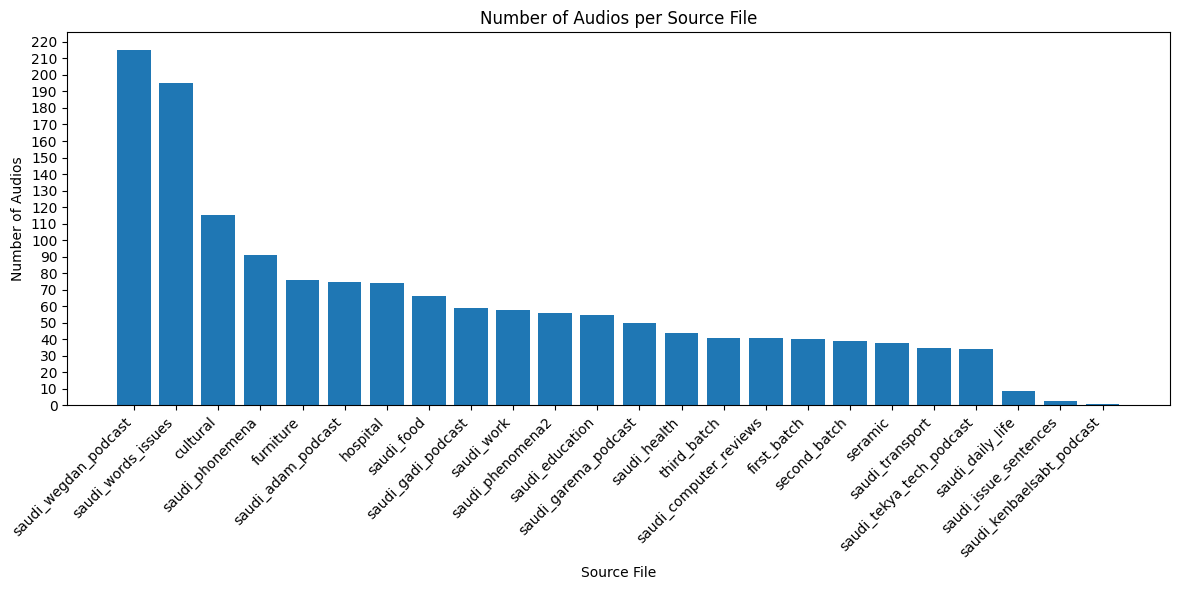

In [23]:
# Get max value
max_count = audio_per_source["audio_count"].max()

# Create y-axis ticks: 0, 10, 20, ..., max
y_ticks = np.arange(0, max_count + 10, 10)

# Visualization
plt.figure(figsize=(12,6))
plt.bar(audio_per_source["source_file_clean"], audio_per_source["audio_count"])
plt.xticks(rotation=45, ha="right")
plt.yticks(y_ticks)
plt.xlabel("Source File")
plt.ylabel("Number of Audios")
plt.title("Number of Audios per Source File")
plt.tight_layout()
plt.show()

##Read and find audio path from drive

In [24]:
AUDIO_PATHS_CSV = '/content/drive/MyDrive/Audio_data/audio_paths.csv'
OUTPUT_SRT_BASE = '/content/drive/MyDrive/Audio_data/STT_outputs'
os.makedirs(OUTPUT_SRT_BASE, exist_ok=True)

In [25]:
def parse_audio_filename(audio_reference):
    """
    Parse audio reference to extract category and batch number

    Example:
    G_SA_saudi_wegdan_podcast_batch_10.wav
    """
    filename = audio_reference.replace('audio/', '')

    pattern = r'G_SA_(.+?)_batch_(\d+)\.wav'
    match = re.match(pattern, filename)

    if match:
        category = match.group(1)
        batch_num = match.group(2)
        return {
            'category': category,
            'batch_num': batch_num,
            'filename': filename
        }
    else:
        print(f"WARNING: Could not parse filename: {filename}")
        return None


In [26]:
def get_actual_audio_path(audio_reference, base_path=ROOT_PATH):
    """
    Convert audio reference to actual file path

    Structure: SA/ → Category_name/ → Category_name_batch_num/ → Category_name_batch_num.wav

    Example:
    Input: 'audio/G_SA_saudi_words_issues_batch_10_0001.wav'
    Output: '/content/drive/.../SA/Saudi_words_issues/Saudi_words_issues_batch_10/Saudi_words_issues_batch_10.wav'

    NOTE: The actual file name is the batch folder name, NOT the CSV reference name!
    """
    parsed = parse_audio_filename(audio_reference)

    if parsed is None:
        return None

    # Capitalize ONLY the first character, keep rest as-is
    # saudi_words_issues → Saudi_words_issues
    category_capitalized = parsed['category'][0].upper() + parsed['category'][1:]

    # Folder name is: Category_name_batch_num (e.g., "Saudi_words_issues_batch_10")
    folder_name = f"{category_capitalized}_batch_{parsed['batch_num']}"

    # IMPORTANT: The actual WAV file name = folder name + .wav
    actual_filename = f"{folder_name}.wav"

    actual_path = os.path.join(
        base_path,
        category_capitalized,
        folder_name,
        actual_filename
    )

    return actual_path

In [27]:
def verify_audio_files(df_audio, sample_size):
    """
    Verify that audio files exist in the expected locations
    """
    print(f"\n{'='*60}")
    print("VERIFYING FILE STRUCTURE")
    print(f"{'='*60}")

    sample = df_audio.head(sample_size)

    found = 0
    not_found = 0

    for idx, row in sample.iterrows():
        audio_ref = row['audio_path']
        actual_path = get_actual_audio_path(audio_ref)

        if actual_path and os.path.exists(actual_path):
            print(f"Found: {audio_ref}")
            found += 1
        else:
            print(f"NOT FOUND: {audio_ref}")
            print(f"  Expected at: {actual_path}")
            not_found += 1

    print(f"\nVerification result: {found}/{sample_size} files found")

    if not_found > 0:
        print(f"\nWARNING: {not_found} files not found!")
        print("Please check the directory structure.")
        return False
    else:
        print("\nAll sample files verified successfully!")
        return True

In [28]:
print("Loading audio paths from CSV...")
df_audio = pd.read_csv(AUDIO_PATHS_CSV)
print(f"Loaded {len(df_audio)} audio references")


Loading audio paths from CSV...
Loaded 16266 audio references


In [29]:
verify_audio_files(df_audio, sample_size=10)


VERIFYING FILE STRUCTURE
NOT FOUND: /content/drive/MyDrive/Generated Data/TTS/Gemini_audacity/To - AI/SA/first_batch/batch_1/batch_1_0.wav
  Expected at: None
NOT FOUND: /content/drive/MyDrive/Generated Data/TTS/Gemini_audacity/To - AI/SA/first_batch/batch_1/eg_wav/Gemini_eg_0000.wav
  Expected at: None
NOT FOUND: /content/drive/MyDrive/Generated Data/TTS/Gemini_audacity/To - AI/SA/first_batch/batch_1/eg_wav/Gemini_eg_0001.wav
  Expected at: None
NOT FOUND: /content/drive/MyDrive/Generated Data/TTS/Gemini_audacity/To - AI/SA/first_batch/batch_1/eg_wav/Gemini_eg_0002.wav
  Expected at: None
NOT FOUND: /content/drive/MyDrive/Generated Data/TTS/Gemini_audacity/To - AI/SA/first_batch/batch_1/eg_wav/Gemini_eg_0003.wav
  Expected at: None
NOT FOUND: /content/drive/MyDrive/Generated Data/TTS/Gemini_audacity/To - AI/SA/first_batch/batch_1/eg_wav/Gemini_eg_0004.wav
  Expected at: None
NOT FOUND: /content/drive/MyDrive/Generated Data/TTS/Gemini_audacity/To - AI/SA/first_batch/batch_1/eg_wav/Gem

False

In [30]:
# try another way to read the audio path
def collect_wav_files(root_folder):
    """
    Collect all .wav files inside a folder and all subfolders
    """
    wav_files = []

    for root, _, files in os.walk(root_folder):
        for file in files:
            if file.lower().endswith(".wav"):
                wav_files.append({
                    "file_name": file,
                    "audio_path": os.path.join(root, file),
                    "folder": os.path.basename(root)
                })

    df = pd.DataFrame(wav_files)
    print(f"Found {len(df)} WAV files")
    return df

In [31]:
df_paths = collect_wav_files(ROOT_PATH)
df_paths

Found 16266 WAV files


,file_name,audio_path,folder
0,batch_1_0.wav,/content/drive/MyDrive/Generated Data/TTS/Gemi...,batch_1
1,Gemini_eg_0000.wav,/content/drive/MyDrive/Generated Data/TTS/Gemi...,eg_wav
2,Gemini_eg_0001.wav,/content/drive/MyDrive/Generated Data/TTS/Gemi...,eg_wav
3,Gemini_eg_0002.wav,/content/drive/MyDrive/Generated Data/TTS/Gemi...,eg_wav
4,Gemini_eg_0003.wav,/content/drive/MyDrive/Generated Data/TTS/Gemi...,eg_wav
...,...,...,...
16261,Saudi_Gadi_Podcast_batch_111.wav,/content/drive/MyDrive/Generated Data/TTS/Gemi...,Saudi_Gadi_Podcast_batch_111
16262,Saudi_Gadi_Podcast_batch_109.wav,/content/drive/MyDrive/Generated Data/TTS/Gemi...,Saudi_Gadi_Podcast_batch_109
16263,Saudi_Gadi_Podcast_batch_1.wav,/content/drive/MyDrive/Generated Data/TTS/Gemi...,Saudi_Gadi_Podcast_batch_1
16264,Saudi_Gadi_Podcast_batch_104.wav,/content/drive/MyDrive/Generated Data/TTS/Gemi...,Saudi_Gadi_Podcast_batch_104


In [32]:
df_paths.to_csv(
    AUDIO_PATHS_CSV,
    index=False
)

In [33]:
# verify_audio_files(df_audio, sample_size=10)

#whisper

In [34]:
## whisper

In [36]:
# setup_whisper()

In [37]:
# import whisper
# from tqdm import tqdm
# import time

In [38]:
%pip install faster-whisper


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.0/38.0 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.2 MB/s eta 0:00:00


In [39]:
import os
import time
import pandas as pd
from tqdm import tqdm
from faster_whisper import WhisperModel


In [40]:
def build_srt_path(audio_path):
    # save the structure of folders
    rel_path = os.path.relpath(audio_path, "/content/drive/MyDrive")
    rel_path = os.path.splitext(rel_path)[0] + ".srt"
    return os.path.join(OUTPUT_SRT_BASE, rel_path)


In [41]:
# convert the transcription into SRT
def segments_to_srt(segments, srt_path):
    os.makedirs(os.path.dirname(srt_path), exist_ok=True)

    def format_time(seconds):
        ms = int((seconds % 1) * 1000)
        s = int(seconds)
        h = s // 3600
        m = (s % 3600) // 60
        s = s % 60
        return f"{h:02}:{m:02}:{s:02},{ms:03}"

    with open(srt_path, "w", encoding="utf-8") as f:
        for i, seg in enumerate(segments, 1):
            f.write(f"{i}\n")
            f.write(f"{format_time(seg.start)} --> {format_time(seg.end)}\n")
            f.write(seg.text.strip() + "\n\n")


In [42]:
# for one file
def transcribe_to_srt(audio_path, srt_path, model):
    segments, _ = model.transcribe(
        audio_path,
        beam_size=5,
        vad_filter=True
    )
    segments_to_srt(list(segments), srt_path)


In [43]:
def process_all_audios(
    df_audio,
    model_size="base",
    save_every=20
):
    print("PROCESSING AUDIO FILES")
    print("=" * 60)

    model = WhisperModel(
        model_size,
        device="cuda",
        compute_type="float16"
    )

    log_path = os.path.join(OUTPUT_SRT_BASE, "processing_log.csv")
    processed = set()

    if os.path.exists(log_path):
        try:
            df_log = pd.read_csv(log_path)
            if "audio_path" in df_log.columns:
                processed = set(df_log["audio_path"])
                print(f"Resuming: {len(processed)} files already processed")
        except:
            print("Could not read log file, starting fresh")

    results = []
    start_time = time.time()

    for _, row in tqdm(df_audio.iterrows(), total=len(df_audio)):
        audio_path = row["audio_path"]

        if audio_path in processed:
            continue

        if not os.path.exists(audio_path):
            results.append({
                "audio_path": audio_path,
                "status": "not_found"
            })
            continue

        srt_path = build_srt_path(audio_path)

        if os.path.exists(srt_path):
            results.append({
                "audio_path": audio_path,
                "status": "already_exists",
                "srt_path": srt_path
            })
            processed.add(audio_path)
            continue

        try:
            transcribe_to_srt(audio_path, srt_path, model)
            results.append({
                "audio_path": audio_path,
                "status": "success",
                "srt_path": srt_path
            })
            processed.add(audio_path)

        except Exception as e:
            results.append({
                "audio_path": audio_path,
                "status": "error",
                "error": str(e)
            })

        if len(results) % save_every == 0:
            pd.DataFrame(results).to_csv(log_path, index=False)

    pd.DataFrame(results).to_csv(log_path, index=False)

    elapsed = time.time() - start_time
    print(f"Finished in {elapsed/60:.1f} minutes")

    return pd.DataFrame(results)


In [44]:
# just for testing
df_test = df_paths

In [45]:
process_all_audios(df_test, model_size="small")


PROCESSING AUDIO FILES


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocabulary.txt: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.bin:   0%|          | 0.00/484M [00:00<?, ?B/s]

RuntimeError: CUDA failed with error CUDA driver version is insufficient for CUDA runtime version

In [ ]:
# def format_timestamp(seconds):
#     """Convert seconds to SRT timestamp format (HH:MM:SS,mmm)"""
#     hours = int(seconds // 3600)
#     minutes = int((seconds % 3600) // 60)
#     secs = int(seconds % 60)
#     millis = int((seconds % 1) * 1000)
#     return f"{hours:02d}:{minutes:02d}:{secs:02d},{millis:03d}"


In [ ]:
# def transcribe_to_srt(audio_path, output_srt_path, model):
#     """
#     Transcribe audio file using Whisper model and save as SRT
#     """
#     result = model.transcribe(audio_path, language="ar", task="transcribe")

#     srt_content = []
#     for i, segment in enumerate(result["segments"], start=1):
#         start_time = format_timestamp(segment["start"])
#         end_time = format_timestamp(segment["end"])
#         text = segment["text"].strip()
#         srt_content.append(f"{i}")
#         srt_content.append(f"{start_time} --> {end_time}")
#         srt_content.append(text)
#         srt_content.append("")

#     os.makedirs(os.path.dirname(output_srt_path), exist_ok=True)
#     with open(output_srt_path, "w", encoding="utf-8") as f:
#         f.write("\n".join(srt_content))

#     return output_srt_path


In [ ]:

# def build_srt_path(audio_path):
#     """
#     Build output SRT path keeping the folder structure
#     under OUTPUT_SRT_BASE.
#     """
#     # Relative path after 'audio/' folder
#     rel_path = os.path.relpath(audio_path, start='audio')
#     # Change extension to .srt
#     rel_path_srt = os.path.splitext(rel_path)[0] + ".srt"
#     # Join with OUTPUT_SRT_BASE
#     full_path = os.path.join(OUTPUT_SRT_BASE, rel_path_srt)
#     # Make sure the directory exists
#     os.makedirs(os.path.dirname(full_path), exist_ok=True)
#     return full_path


In [ ]:

# def process_all_audios(
#     df_audio,
#     model_size="base",
#     save_every=20
# ):
#     print("PROCESSING AUDIO FILES")
#     print("=" * 60)

#     model = whisper.load_model(model_size)

#     log_path = os.path.join(OUTPUT_SRT_BASE, "processing_log.csv")
#     processed = set()

#     if os.path.exists(log_path):
#         try:
#             df_log = pd.read_csv(log_path)
#             if "audio_path" in df_log.columns:
#                 processed = set(df_log["audio_path"])
#                 print(f"Resuming from log: {len(processed)} files already done")
#             else:
#                 print(f"WARNING: Log file '{log_path}' exists but does not contain 'audio_path' column. Starting fresh.")
#         except Exception as e:
#             print(f"WARNING: Could not read log file '{log_path}' due to error: {e}. Starting fresh.")

#     results = []
#     start_time = time.time()

#     for _, row in tqdm(df_audio.iterrows(), total=len(df_audio)):
#         audio_path = row["audio_path"]

#         if audio_path in processed:
#             continue

#         if not os.path.exists(audio_path):
#             results.append({
#                 "audio_path": audio_path,
#                 "status": "not_found"
#             })
#             continue

#         srt_path = build_srt_path(audio_path)

#         if os.path.exists(srt_path):
#             results.append({
#                 "audio_path": audio_path,
#                 "status": "already_exists",
#                 "srt_path": srt_path
#             })
#             processed.add(audio_path)
#             continue

#         try:
#             transcribe_to_srt(audio_path, srt_path, model)
#             results.append({
#                 "audio_path": audio_path,
#                 "status": "success",
#                 "srt_path": srt_path
#             })
#             processed.add(audio_path)

#         except Exception as e:
#             results.append({
#                 "audio_path": audio_path,
#                 "status": "error",
#                 "error": str(e)
#             })

#         if len(results) % save_every == 0:
#             pd.DataFrame(results).to_csv(log_path, index=False)

#     pd.DataFrame(results).to_csv(log_path, index=False)

#     elapsed = time.time() - start_time
#     print(f"Finished in {elapsed/60:.1f} minutes")

#     return pd.DataFrame(results)

In [ ]:
# df_paths.columns

In [ ]:
# df_audio = df_paths  # columns: 'file_name', 'audio_path', 'folder'


In [ ]:
# df_audio

In [ ]:
# results_df = process_all_audios(df_audio, model_size="base", save_every=20)


#omnilingual
